# 사전 학습 모델과 전이학습

CNN 훈련에는 많은 시간이 소요될 수 있으며 해당 작업에는 많은 데이터가 필요합니다. 그러나 네트워크가 이미지에서 Pattern을 추출하는 데 사용하는 최상의 저수준(Low-Level) Filter를 학습하는 데 많은 시간이 소요됩니다. 자연스러운 질문이 생깁니다. 하나의 데이터셋에서 훈련된 신경망을 사용하여 완전한 훈련 프로세스 없이 다른 이미지를 분류하는 데 적용할 수 있을까요?

이 접근 방식을 **전이 학습(Transfer Learning)** 이라고 합니다. 하나의 신경망 모델에서 다른 신경망 모델로 일부 지식을 이전하기 때문에 전이 학습이라고 부릅니다. 전이 학습에서는 일반적으로 **ImageNet**과 같은 일부 대형 이미지 데이터셋에 대해 학습된 사전 학습된(Pre-Trained) 모델로 시작합니다. 이러한 모델은 일반 이미지에서 다른 특징을 추출하는 데 좋은 작업을 수행할 수 있으며, 대부분의 경우 추출된 특징 위에 분류기를 구축하는 것만으로도 좋은 결과를 얻을 수 있습니다.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

## Cats vs. Dogs Dataset

이번 챕터에서는 실제 고양이와 개의 이미지를 분류하는 문제를 해결합니다. 따라서 [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats)을 사용하며, [Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765)에서 다운로드할 수 있습니다.

이 데이터 세트를 `data` 경로에 다운로드하겠습니다.

In [2]:
if not os.path.exists('data/kagglecatsanddogs_3367a.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [3]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

안타깝게도 데이터셋에 손상된 이미지 파일이 있습니다. 손상된 파일을 확인하려면 빠른 정리를 해야합니다. 이 튜토리얼을 방해하지 않기 위해 코드를 이동하여 데이터 세트를 검증했습니다.

In [4]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image: data/PetImages/Cat/666.jpg
Corrupt image: data/PetImages/Dog/11702.jpg


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin

다음으로 이미지를 PyTorch 데이터셋에 불러오고 Tensor로 변환하고 일부 Normalization을 수행합니다. `std_normalize` 변환을 적용하여 사전 훈련된 VGG 네트워크에서 기대하는 범위로 이미지를 가져옵니다.

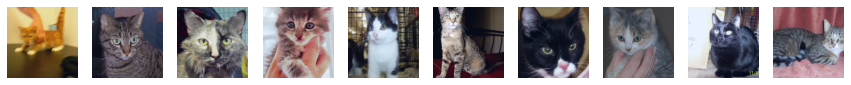

In [5]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset)

## Pre-trained models

`torchvision` 모듈에는 다양한 사전 훈련된 모델이 있으며 인터넷에서 더 많은 모델을 찾을 수 있습니다. 가장 간단한 VGG-16 모델을 불러오고 사용할 수 있는 방법을 살펴보겠습니다.

In [6]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

tensor(282)


우리가 받은 결과는 다수의`ImageNet` 클래스이며 [여기](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)에서 조회할 수 있습니다. 다음 코드를 사용하여 이 클래스 테이블을 자동으로 불러오고 결과를 반환할 수 있습니다.

In [7]:
import json, requests
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

VGG-16 네트워크의 아키텍처도 살펴보겠습니다.

In [10]:
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 512, 7, 7]            --
|    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
|    └─ReLU: 2-2                         [1, 64, 224, 224]         --
|    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
|    └─ReLU: 2-4                         [1, 64, 224, 224]         --
|    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
|    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
|    └─ReLU: 2-7                         [1, 128, 112, 112]        --
|    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
|    └─ReLU: 2-9                         [1, 128, 112, 112]        --
|    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
|    └─Conv2d: 2-11                      [1, 256, 56, 56]          295,168
|    └─ReLU: 2-12                        [1, 256, 56, 56]       

이미 알고있는 Layer 외에도 **Dropout**이라는 다른 Layer가 있습니다. 이러한 Layer는 **Regularization** 기술로 작동합니다. Regularization는 학습 알고리즘을 약간 수정하여 모델이 더 잘 일반화되도록 합니다. 훈련 중에 Dropout Layer는 이전 Layer에 있는 뉴런의 일부(약 30 %)를 버리고 훈련은 이들 없이 진행합니다. 이는 최적화 프로세스를 지역 국솟값(Local Minimum)에서 벗어나 다른 신경 경로 간에 결정적인 힘을 분산시켜 네트워크의 전반적인 안정성을 향상시키는 데 도움이 됩니다.

## GPU computations

VGG-16 및 기타 최신 아키텍처와 같은 심층 신경망을 실행하려면 상당한 계산 능력이 필요합니다. 가능한 경우 GPU 가속을 사용하는 것이 좋습니다. 그렇게 하려면 계산에 관련된 모든 텐서를 명시적으로 GPU로 이동시켜야 합니다.

일반적으로 이 방법은 코드에서 GPU의 가용성을 확인하고 컴퓨팅 장치(GPU 또는 CPU)를 가리키는 `device` 변수를 정의하는 것입니다.

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cuda


tensor(281, device='cuda:0')

## Extracting VGG features

VGG-16을 사용하여 이미지에서 Feature를 추출하려면 최종 분류 Layer가 없는 모델이 필요합니다. 이 "Feature Extraction"은 `vgg.features` 메소드를 사용하여 얻을 수 있습니다.

In [12]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

torch.Size([1, 512, 7, 7])


Feature Tensor의 크기는 512x7x7이지만 이를 시각화하기 위해 2D 형식으로 모양을 변경합니다.

이제 이러한 Feature를 이미지 분류에 사용할 수 있는지 살펴보겠습니다. 이미지의 일부(이 경우 800)를 수동으로 가져 와서 Feature 벡터를 미리 계산해 보겠습니다. 결과를 `feature_tensor`라는 하나의 큰 Tensor에 저장하고 레이블을` label_tensor`에 저장합니다.

In [13]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break


....................................................................................................

이제 이 Tensor에서 데이터를 가져오는 `vgg_dataset`를 정의하고, `random_split` 함수를 사용하여 훈련 세트와 평가 세트로 분할하고 추출된 Feature 위에 작은 One-Layer Desne 분류기 네트워크를 훈련시킬 수 있습니다.

In [14]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  0, Train acc=0.859, Val acc=0.980, Train loss=0.151, Val loss=0.048
Epoch  1, Train acc=0.984, Val acc=0.990, Train loss=0.018, Val loss=0.006
Epoch  2, Train acc=0.989, Val acc=0.960, Train loss=0.014, Val loss=0.109
Epoch  3, Train acc=0.997, Val acc=0.980, Train loss=0.003, Val loss=0.028
Epoch  4, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.022
Epoch  5, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.022
Epoch  6, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.023
Epoch  7, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.023
Epoch  8, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.024
Epoch  9, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.024


결과는 훌륭합니다. 거의 98% 확률로 고양이와 개를 구분할 수 있습니다! 그러나 수동 Feature 추출에 많은 시간이 걸릴 수 있기 때문에 모든 이미지의 작은 하위 집합에서만 이 방법을 테스트했습니다.

## Transfer learning using one VGG network

훈련 중에 기존 VGG-16 네트워크를 전체적으로 사용하여 Feature를 수동으로 사전 계산(pre-compute)하는 것을 방지할 수 있습니다. VGG-16의 구조를 살펴보겠습니다.

In [15]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

네트워크에는 다음이 포함되어 있습니다.
* Feature 추출(`features`) : 여러 Convolution 및 Pool Layer로 구성
* Average Pooling Layer(`avgpool`)
* `classifier` : 여러 개의 Dense Layer로 구성되어 25,088개의 입력 Feature를 1000개의 클래스(Imagenet의 클래스 수)로 변환합니다.

데이터셋을 분류하기 위해 End-to-End 모델을 훈련하려면 다음을 수행해야합니다.
* 최종 분류기를 필요한 수의 클래스를 생성할 분류기로 교체합니다. 이 경우 25088개의 입력과 2개의 출력 뉴런이 있는 하나의 선형 Layer를 사용할 수 있습니다.
* Convolution Feature Extraction의 가중치를 고정하여 학습되지 않도록 합니다. 그렇지 않으면 훈련되지 않은 분류기 Layer가 Convolutional Feature Extraction의 사전 훈련된 가중치를 파괴할 수 있으므로 처음에는 동결(Freezing)을 수행하는 것이 좋습니다. 가중치 고정은 모든 매개 변수의 `requires_grad`를 `False`로 설정하여 수행할 수 있습니다.

In [16]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

summary에서 볼 수 있듯이 이 모델에는 약 1,500만 개의 매개 변수가 포함되어 있지만 그중 5만 개만 훈련이 가능하며, 이는 분류기 Layer의 가중치입니다. 더 적은 수의 예제로 더 적은 수의 매개 변수를 미세 조정(Fine-Tuning)할 수 있기 때문에 좋습니다.

이제 원래 데이터셋을 사용하여 모델을 훈련해 보겠습니다. 이 과정은 시간이 오래 걸리므로 Epoch가 끝날 때까지 기다리지 않고 중간 결과를 출력하는 `train_long` 함수를 사용합니다. GPU 지원 컴퓨팅에서 이 훈련을 실행하는 것을 권장합니다.

In [17]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.5625, train loss = 0.045165419578552246
Epoch 0, minibatch 90: train acc = 0.945054945054945, train loss = 0.10654432694990557
Epoch 0, minibatch 180: train acc = 0.9558011049723757, train loss = 0.10983258452863325
Epoch 0, minibatch 270: train acc = 0.9612546125461254, train loss = 0.11056054034356262
Epoch 0, minibatch 360: train acc = 0.9657202216066482, train loss = 0.09974451672667611
Epoch 0, minibatch 450: train acc = 0.9667405764966741, train loss = 0.10326384652215996
Epoch 0, minibatch 540: train acc = 0.9695009242144177, train loss = 0.1081675954314565


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin

Epoch 0, minibatch 630: train acc = 0.9695919175911252, train loss = 0.11688086121282562
Epoch 0, minibatch 720: train acc = 0.9707871012482663, train loss = 0.1197152633772809
Epoch 0, minibatch 810: train acc = 0.9708692971639951, train loss = 0.12544860087252427
Epoch 0, minibatch 900: train acc = 0.9710044395116537, train loss = 0.1342598833598519
Epoch 0, minibatch 990: train acc = 0.972061049445005, train loss = 0.13815826508399817
Epoch 0, minibatch 1080: train acc = 0.9726526364477336, train loss = 0.140142435502609
Epoch 0, minibatch 1170: train acc = 0.9720858240819812, train loss = 0.15663393250293553
Epoch 0 done, validation acc = 0.9817927170868347, validation loss = 0.15710224519495297


상당히 정확한 고양이 vs 개 분류기를 얻은 것 같습니다! 나중에 사용할 수 있도록 저장합시다!

In [18]:
torch.save(vgg,'data/cats_dogs.pth')

그런 다음 언제든지 파일에서 모델을 불러올 수 있습니다. 다음 실험에서 모델을 파괴하는 경우 유용하게 사용할 수 있으며, 처음부터 다시 시작할 필요가 없습니다.

In [19]:
vgg = torch.load('data/cats_dogs.pth')

## Fine-tuning transfer learning

이전 섹션에서는 데이터셋의 이미지를 분류하기 위해 최종 분류기 Layer를 훈련했습니다. 그러나 Feature Extraction은 다시 훈련하지 않았으며, ImageNet 데이터에서 학습한 결과에 의존했습니다. 개체가 일반 ImageNet 이미지와 시각적으로 다른 경우 기존 학습 결과가 잘 작동하지 않을 수 있기 때문에, Convolutional Layer 또한 학습을 진행하는 것이 좋습니다.

이를 위해 이전에 고정한 Convolutional Filter 파라미터의 고정을 해제 할 수 있습니다.

> **Note:** 분류 Layer에서 가중치를 안정화하려면 먼저 매개 변수를 고정하고 여러 Epoch의 훈련을 수행하는 것이 중요합니다. 고정되지 않은 매개 변수로 End-to-End 네트워크 훈련을 즉시 시작할 경우 큰 오류가 발생하면 Convolutional Layer에서 사전 훈련 된 가중치를 파괴할 가능성이 있습니다.

In [20]:
for x in vgg.features.parameters():
    x.requires_grad = True

고정을 해제 한 후 몇 번의 Epoch를 더 진행할 수 있습니다. 사전 훈련된 가중치에 미치는 영향을 최소화하기 위해 더 낮은 학습률을 선택할 수도 있습니다. 그러나 학습률이 낮더라도 훈련 시작시 정확도가 떨어질 수 있으나, 최종적으로 고정 가중치의 경우보다 약간 높은 수준에 도달할 수 있습니다.

> **Note:** 이 훈련은 네트워크의 여러 Layer를 통해 다시 Gradient를 전파해야하므로 훨씬 느리게 진행됩니다! 처음 몇 개의 minibatch에서 경향을 확인한 다음 계산을 중지할 수 있습니다.

In [21]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

Epoch 0, minibatch 0: train acc = 0.9375, train loss = 0.05164256691932678
Epoch 0, minibatch 90: train acc = 0.9237637362637363, train loss = 0.22198507288000086
Epoch 0, minibatch 180: train acc = 0.9350828729281768, train loss = 0.1316179834018096
Epoch 0, minibatch 270: train acc = 0.9446494464944649, train loss = 0.09719027980227311
Epoch 0, minibatch 360: train acc = 0.9510041551246537, train loss = 0.07776963083367598
Epoch 0, minibatch 450: train acc = 0.9542682926829268, train loss = 0.0652109091139157
Epoch 0, minibatch 540: train acc = 0.9554066543438078, train loss = 0.057144408305339144
Epoch 0, minibatch 630: train acc = 0.9562202852614897, train loss = 0.051035371710872496
Epoch 0, minibatch 720: train acc = 0.9535367545076283, train loss = 0.048412391778996186
Epoch 0, minibatch 810: train acc = 0.9558415536374846, train loss = 0.043707310197973664
Epoch 0, minibatch 900: train acc = 0.9573390677025527, train loss = 0.04010265490058789
Epoch 0, minibatch 990: train acc 

## Other computer vision models

VGG-16은 가장 간단한 컴퓨터 비전 아키텍처 중 하나이며, `torchvision` 패키지는 더 많은 사전 훈련된 네트워크를 제공합니다. 그 중 가장 자주 사용되는 아키텍처는 Microsoft에서 개발 한 **ResNet** 아키텍처와 Google에서 제공하는 **Inception**입니다. 예를 들어 가장 간단한 ResNet-18 모델의 아키텍처를 살펴 보겠습니다(ResNet은 각각 깊이가 다른 모델로, 정말 깊은 모델이 어떻게 생겼는지 확인하려면 ResNet-151을 사용해 볼 수 있습니다).

In [22]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

보시다시피 모델에는 Feature Extraction과 최종 분류기(`fc`)라는 동일한 구성 요소가 포함되어 있습니다. 이를 통해 전이 학습에 VGG-16을 사용했던 것과 똑같은 방식으로 이 모델을 사용할 수 있습니다. 다른 ResNet 모델을 기본 모델로 사용하여 위의 코드를 실험해보고 정확도가 어떻게 변하는 지 확인할 수 있습니다.

이 네트워크에는 **Batch Normalization**이라는 또 다른 유형의 Layer가 포함되어 있습니다. Batch Normalization의 아이디어는 신경망을 통해 흐르는 값을 올바른 간격으로 가져 오는 것입니다. 일반적으로 신경망은 모든 값이 [-1,1] 또는 [0,1] 범위에 있을 때 가장 잘 작동하며 그에 따라 입력 데이터를 Scale 또는 Normalize하는 이유입니다.

## Takeaway

전이 학습을 사용하여 사용자 지정 객체 분류 작업을 위한 분류기를 신속하게 구성하고 높은 정확도를 달성 할 수 있었습니다. 그러나 이 예제는 완전히 공평하지 않았습니다. 원래의 VGG-16 네트워크는 고양이와 개를 인식하도록 미리 훈련되었기 때문이며, 그로 인해 네트워크에 이미 존재하는 대부분의 패턴을 다시 사용하고 있었습니다. 공장의 생산 라인에 대한 세부 정보나 다른 나무의 잎과 같은 보다 특이한 도메인별 개체에서는 정확도가 낮아질 수 있습니다.

이제 우리가 해결하고 있는 더 복잡한 작업은 더 높은 계산 능력을 필요로 하며 CPU에서 쉽게 해결할 수 없음을 알 수 있습니다. 다음 챕터에서는 보다 가벼운 구현을 사용하여 결과적으로 정확도가 약간 낮아지더라도 더 낮은 컴퓨팅 리소스를 사용하여 동일한 모델을 훈련시키고자 합니다.